## Load File

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import imageio
import os
from tqdm import tqdm  # For progress bars

filename = 'δ=0=Ro=4_F=1_closure2.nc' #remember.nc at the end
ds = xr.open_dataset(filename, engine = 'netcdf4', decode_times=False)


# Non-dimensionalising timescale

f = 1e-4

# Rescale time: convert seconds to non-dimensional time = f * t
# Ensure 'time' is in seconds (if it's in days, convert to seconds first)
time = ds.time.values
nondim_time =  time * f 


# Add non-dimensional time to dataset for convenience
ds = ds.assign_coords(nondim_time=("time", nondim_time))


## Buoyancy Animation

In [56]:
# contours working

b = ds['b'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, b_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='Buoyancy (m/s²)')  
    
    
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    #ax.set_xlim(-1,1)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:14<00:00,  1.40it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_27320\283208188.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1063, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


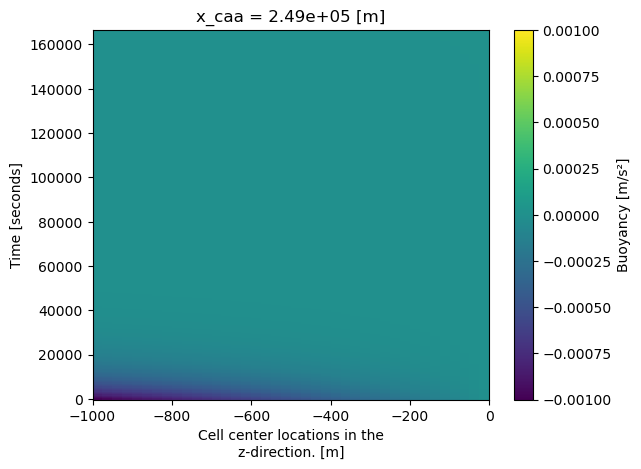

In [37]:

ds.b[:,:,-1].plot(vmin = -0.001, vmax = 0.001)


## Along fron velocity (u)

In [35]:
# contours not working

u = ds['u'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(u.quantile(0.05)), float(u.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    u_data = u.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, u_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_u.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 41/41 [00:22<00:00,  1.83it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_27320\2593955291.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1071, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Along jet velocity (v)

In [34]:
# contours not working

v = ds['v'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v.quantile(0.05)), float(v.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    v_data = v.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, v_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, along jet (v)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:17<00:00,  2.32it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_27320\3530609042.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1073, 586) to (1088, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Vertical velocity (w)

In [51]:
# contours not working

w = ds['w'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(w.quantile(0.05)), float(w.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    w_data = w.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, w_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
            levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, vertical (w)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_w.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 70/70 [00:35<00:00,  1.97it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_27320\692373657.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


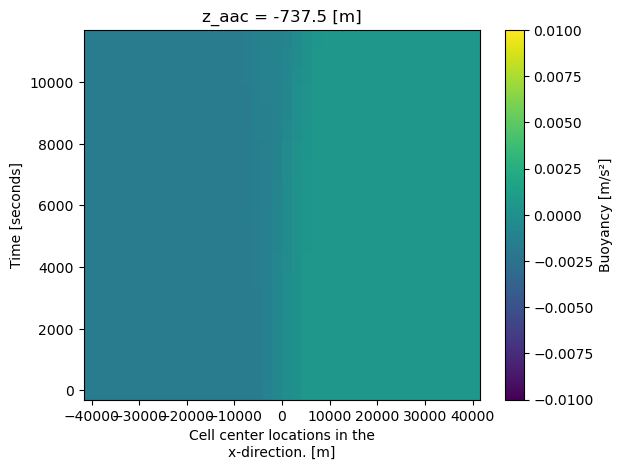

In [ ]:
ds.b[:20,10,100:140].plot(vmin = -0.01, vmax = 0.01)